In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import datasets, transforms
import numpy as np
from ewc import EWC
import generate_datasets as ds

In [17]:
# Helper function to evaluate the model
def evaluate_model(model, dataloader, device='cuda'):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    return correct / total


In [18]:
def train_model(model, train_dataloader, test_dataloaders, criterion, optimizer, ewc=None, lambda_ewc=0.0, epochs=20, device='cuda'):
    model.train()
    accuracies = np.zeros((epochs, len(test_dataloaders)))
    for epoch in range(epochs):
        total_loss = 0
        
        for inputs, targets in train_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            task_loss = criterion(outputs, targets)

            # Add regularization loss if applicable
            ewc_loss = ewc.compute_ewc_loss(model, lambda_ewc) if ewc else 0.0
            loss = task_loss + ewc_loss

            loss.backward()
            optimizer.step()
            total_loss += task_loss.item()

        # Evaluate the model after each epoch on each test set
        for i, test_dataloader in enumerate(test_dataloaders):
            accuracy = evaluate_model(model, test_dataloader, device)
            accuracies[epoch, i] = accuracy
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_dataloader):.4f}, Accuracy on task {i}: {accuracy:.4f}")

    return accuracies


In [19]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load permuted datasets
permuted_train_loaders, permuted_test_loaders, _, _ = ds.load_datasets()

In [20]:
from MNIST_functions import CustomNN, EarlyStopping, set_experiment_params

# Set experiment parameters
params = set_experiment_params('2A')
learning_rate = params['learning_rate']
dropout_input = params['dropout_input']
dropout_hidden = params['dropout_hidden']
early_stopping_enabled = params['early_stopping_enabled']
num_hidden_layers = params['num_hidden_layers']
width_hidden_layers = params['width_hidden_layers']
epochs = params['epochs']

# Initialize the model, criterion, optimizer, and early stopping
model_ewc = CustomNN(num_hidden_layers=num_hidden_layers, hidden_size=width_hidden_layers, dropout_input=dropout_input, dropout_hidden=dropout_hidden).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ewc.parameters(), lr=learning_rate)
early_stopping = EarlyStopping(patience=5) if early_stopping_enabled else None

# Train on first task with EWC
ewc = EWC(model_ewc)
accuracies_a = train_model(model_ewc, permuted_train_loaders[0], permuted_test_loaders[0:1], criterion, optimizer, ewc=ewc, lambda_ewc=10000, epochs=epochs, device=device)

ewc.compute_fisher(permuted_train_loaders[0])
ewc.update_params()

# Train on second task with EWC
accuracies_b = train_model(model_ewc, permuted_train_loaders[1], permuted_test_loaders[0:2], criterion, optimizer, ewc=ewc, lambda_ewc=10000, epochs=epochs, device=device)

ewc.compute_fisher(permuted_train_loaders[1])
ewc.update_params()

# Train on third task with EWC
accuracies_c = train_model(model_ewc, permuted_train_loaders[2], permuted_test_loaders[0:3], criterion, optimizer, ewc=ewc, lambda_ewc=10000, epochs=epochs, device=device)


Epoch 1/20, Loss: 0.4277, Accuracy on task 0: 0.9407
Epoch 2/20, Loss: 0.1399, Accuracy on task 0: 0.9560
Epoch 3/20, Loss: 0.0941, Accuracy on task 0: 0.9616
Epoch 4/20, Loss: 0.0685, Accuracy on task 0: 0.9623
Epoch 5/20, Loss: 0.0527, Accuracy on task 0: 0.9653
Epoch 6/20, Loss: 0.0406, Accuracy on task 0: 0.9676
Epoch 7/20, Loss: 0.0322, Accuracy on task 0: 0.9677
Epoch 8/20, Loss: 0.0255, Accuracy on task 0: 0.9688
Epoch 9/20, Loss: 0.0206, Accuracy on task 0: 0.9705
Epoch 10/20, Loss: 0.0166, Accuracy on task 0: 0.9699
Epoch 11/20, Loss: 0.0139, Accuracy on task 0: 0.9699
Epoch 12/20, Loss: 0.0116, Accuracy on task 0: 0.9703
Epoch 13/20, Loss: 0.0099, Accuracy on task 0: 0.9710
Epoch 14/20, Loss: 0.0084, Accuracy on task 0: 0.9710
Epoch 15/20, Loss: 0.0074, Accuracy on task 0: 0.9718
Epoch 16/20, Loss: 0.0064, Accuracy on task 0: 0.9717
Epoch 17/20, Loss: 0.0058, Accuracy on task 0: 0.9714
Epoch 18/20, Loss: 0.0051, Accuracy on task 0: 0.9717
Epoch 19/20, Loss: 0.0046, Accuracy o

In [21]:
# evaluate on all tasks
acc_a_ewc = evaluate_model(model_ewc, permuted_test_loaders[0], device=device)
acc_b_ewc = evaluate_model(model_ewc, permuted_test_loaders[1], device=device)
acc_c_ewc = evaluate_model(model_ewc, permuted_test_loaders[2], device=device)

print(f"EWC - Accuracy on Task A: {acc_a_ewc:.2f}, Task B: {acc_b_ewc:.2f}, Task C: {acc_c_ewc:.2f}")

EWC - Accuracy on Task A: 0.96, Task B: 0.97, Task C: 0.96


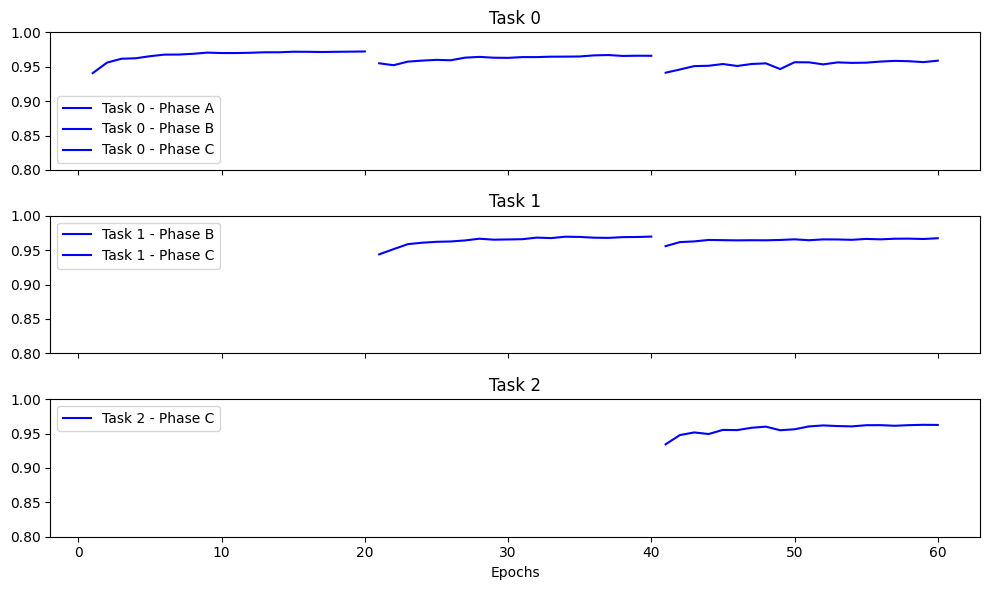

In [22]:
# plot separately accuracies on task 0, 1, 2
# task 0 is present in accuracies_a, accuracies_b, accuracies_c; task 1 is present in accuracies_b, accuracies_c; task 2 is present in accuracies_c
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 1, figsize=(10, 6), sharex=True)
# Plot accuracies for Task 0
axes[0].plot(np.arange(1, epochs + 1), accuracies_a[:, 0], label='Task 0 - Phase A', color='blue')
axes[0].plot(np.arange(epochs + 1, 2 * epochs + 1), accuracies_b[:, 0], label='Task 0 - Phase B', color='blue')
axes[0].plot(np.arange(2 * epochs + 1, 3 * epochs + 1), accuracies_c[:, 0], label='Task 0 - Phase C', color='blue')
axes[0].set_title('Task 0')
axes[0].legend()
axes[0].set_ylim(0.8, 1.0)

# Plot accuracies for Task 1
axes[1].plot(np.arange(epochs + 1, 2 * epochs + 1), accuracies_b[:, 1], label='Task 1 - Phase B', color='blue')
axes[1].plot(np.arange(2 * epochs + 1, 3 * epochs + 1), accuracies_c[:, 1], label='Task 1 - Phase C', color='blue')
axes[1].set_title('Task 1')
axes[1].legend()
axes[1].set_ylim(0.8, 1.0)

# Plot accuracies for Task 2
axes[2].plot(np.arange(2 * epochs + 1, 3 * epochs + 1), accuracies_c[:, 2], label='Task 2 - Phase C', color='blue')
axes[2].set_title('Task 2')
axes[2].legend()
axes[2].set_ylim(0.8, 1.0)

# Set common labels
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()
